#UTILITY FUNCTIONS

In [112]:
import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict


def split_data(X, y, test_size=0.1, seed=None):
    # shuffle data
    np.random.seed(seed)
    perm = np.random.permutation(X.index)
    X = X.loc[perm]
    y = y.loc[perm]
    
    # split into training and test sets
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        if test_size <= 0 or test_size >= 1:
            raise ValueError("The test size should fall in the range (0,1)")
        n_train = n_samples - round(test_size*n_samples)
    elif isinstance(test_size, int):
        n_train = n_samples - test_size
    else:
        raise ValueError("Improper type \'%s\' for test_size" % type(test_size))

    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, X_test, y_train, y_test

def encode_one_hot(data): # note: pd.get_dummies(df) does the same
    # https://www.kite.com/python/answers/how-to-do-one-hot-encoding-with-numpy-in-python
    one_hot = np.zeros((data.size, data.max()+1))
    rows = np.arange(data.size)
    one_hot[rows, data] = 1
    return one_hot


def confusion_matrix(y_actual, y_pred):
    """ Returns a confusion matrix where the rows are the actual classes, and the columns are the predicted classes"""
    if y_actual.shape != y_pred.shape:
        raise ValueError ("input arrays must have the same shape, {}!={}".format(y_actual.shape, y_pred.shape))
    n = max(max(y_actual), max(y_pred)) + 1
    C = np.zeros((n, n), dtype=int)
    for label_actual in range(n):
        idxs_true = (y_actual == label_actual)
        for label_pred in range(n):
            C[label_actual, label_pred] = sum(y_pred[idxs_true] == label_pred)
    return C

def calc_f1_score(y_actual, y_pred) -> Tuple[float]:
    C = confusion_matrix(y_actual, y_pred)
    if C.shape[0] != 2:
        raise ValueError ("input arrays must only have binary values")
    recall    = C[1][1]/(C[1][0]+C[1][1]) #true positive/actual positive
    precision = C[1][1]/(C[0][1]+C[1][1]) #true positive/predicted positive
    if (recall == 0) or (precision == 0):
        f1 = 0
    else:
        f1 = 2 * recall*precision/(recall + precision) # = 2/((1/recall)+(1/precision))

    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("F1 Score: {:.4f}".format(f1))


In [113]:
import numpy as np
import pickle

class LogisticRegression:
    """Logistic regression model."""
    def __init__(self, learning_rate=0.01, num_iterations=10000, fit_intercept=True):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
    
    def add_intercept(self, X):
        """Add intercept to data."""
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def sigmoid(self, z):
        """Compute the sigmoid function of the input."""
        return 1 / (1 + np.exp(-z))

    def loss(self, y, h):
        """Compute the binary cross-entropy loss."""
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        """Fit logistic regression model to data."""
        if self.fit_intercept:
            X = self.add_intercept(X)

        # Initialize model parameters
        self.theta = np.zeros(X.shape[1])

        # Perform gradient descent
        for i in range(self.num_iterations):
            # Compute predicted probabilities
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)

            # Compute gradients
            gradient = np.dot(X.T, (h - y)) / y.size

            # Update model parameters
            self.theta -= self.learning_rate * gradient

            # Print loss every 1000 iterations
            if i % 1000 == 0:
                z = np.dot(X, self.theta)
                h = self.sigmoid(z)
                loss = self.loss(y, h)
                print(f'Iteration {i}, Loss: {loss}')

    def predict(self, X):
        """Make predictions using logistic regression model."""
        if self.fit_intercept:
            X = self.add_intercept(X)

        # Compute predicted probabilities
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)

        # Return binary predictions
        return (h > 0.5).astype(int)

    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def save(self, filename):
        """Save trained model parameters to a pickle file."""
        with open(filename, 'wb') as f:
            pickle.dump(self.theta, f)

    @classmethod
    def load(cls, filename):
        """Load trained model parameters from a pickle file."""
        model = cls()
        with open(filename, 'rb') as f:
            model.theta = pickle.load(f)
        return model


#ADULT INCOME PREDICTION


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [115]:
df1=pd.read_csv('/content/adult_income.csv')
df2=pd.read_csv('/content/adult_income1.csv')
df1.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family
2,66,?,186061,Some-college,10,Widowed,?,Unmarried
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child


In [116]:
df2.head()

,occupation,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,?,White,Female,0,4356,40,United-States,<=50K
1,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
2,?,Black,Female,0,4356,40,United-States,<=50K
3,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
4,Prof-specialty,White,Female,0,3900,40,United-States,<=50K


In [117]:
#Adding new feature 'Index'
df2 = df2.reset_index(drop=True)
df2['index']=df2.index

In [118]:
df1.shape,df2.shape

((32561, 8), (32561, 9))

In [119]:
df2.drop(['occupation'],axis=1,inplace=True)

In [120]:
df = pd.merge(df1, df2, left_index=True,right_index=True)

In [121]:
df.drop(['index'],axis=1,inplace=True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [122]:
df.shape

(32561, 15)

<=50K    24720
>50K      7841
Name: income, dtype: int64


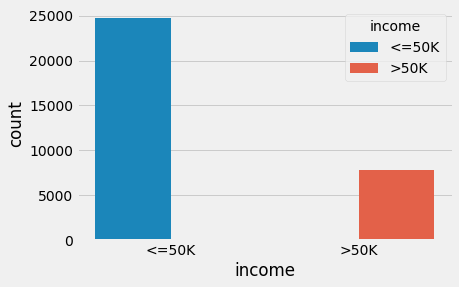

In [123]:
# TARGET DISTRIBUTION PLOT
print(df['income'].value_counts()) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df.income, data=df, hue=df.income)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [125]:
#Checking for duplication of data
df.duplicated().sum()

24

In [126]:
df = df.drop_duplicates()
df.shape

(32537, 15)

In [127]:
cat_col = df.select_dtypes(include=['object']).columns
cat_col

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')

In [128]:
#Checking for '?' in categorcal features
print('% of missing values :')
for c in cat_col:
    perc = len(df[df[c] == '?']) / df.shape[0] * 100
    print(c, f'{perc:.1f} %')

% of missing values :
workclass 5.6 %
education 0.0 %
marital.status 0.0 %
occupation 5.7 %
relationship 0.0 %
race 0.0 %
sex 0.0 %
native.country 1.8 %
income 0.0 %


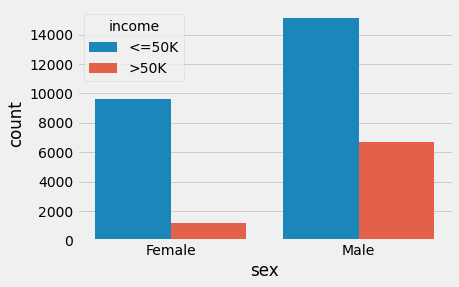

In [129]:
plt.style.use('fivethirtyeight')
ax = sns.countplot(x=df.sex, data=df, hue=df.income)

In [130]:
# no of female / male
no_female = (df.sex == 'Female').astype('int').sum()
no_male = (df.sex == 'Male').astype('int').sum()
no_female, no_male

(10762, 21775)

In [131]:
# no of people earning more or less than 50k per gender
no_male_above = len(df[(df.income == '>50K') & (df.sex == 'Male')])
no_male_below = len(df[(df.income == '<=50K') & (df.sex == 'Male')])
no_female_above = len(df[(df.income == '>50K') & (df.sex == 'Female')])
no_female_below = len(df[(df.income == '<=50K') & (df.sex == 'Female')])
no_male_above, no_male_below, no_female_above, no_female_below

(6660, 15115, 1179, 9583)

In [132]:
no_male_above /= no_male 
no_male_below /= no_male
no_female_above /= no_female
no_female_below /= no_female
no_male_above, no_male_below, no_female_above, no_female_below

(0.3058553386911596,
 0.6941446613088404,
 0.1095521278572756,
 0.8904478721427244)

In [133]:
print(f'Among people earning >50K  : {no_male_above / (no_male_above + no_female_above) *100 :.0f}% are Females and {no_female_above / (no_male_above + no_female_above) *100 :.0f}% are Males')
print(f'Among people earning =<50K : {no_male_below / (no_male_below + no_female_below) *100 :.0f}% are Females and {no_female_below / (no_male_below + no_female_below) *100 :.0f}% are Males')

Among people earning >50K  : 74% are Females and 26% are Males
Among people earning =<50K : 44% are Females and 56% are Males


In [134]:
#Taking only numerical features for analysis
num_col = df.select_dtypes(include=['float', 'int']).columns
num_col

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

<Axes: >

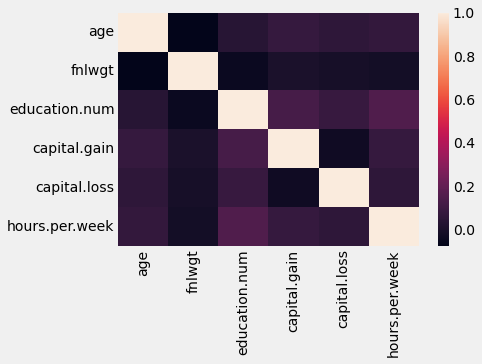

In [135]:
sns.heatmap(df.corr())

In [136]:
# Preprocessing on target feature
df.income.value_counts()

<=50K    24698
>50K      7839
Name: income, dtype: int64

In [137]:
df['income'] = pd.get_dummies(df['income'], prefix='income', drop_first=True)
y = df.income
df = df.drop(columns=['income'])

In [138]:
cat_col = df.select_dtypes(include=['object']).columns
X = pd.get_dummies(df[cat_col], drop_first=True)

In [139]:
X.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [140]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [141]:
# Fit the scaler to your training data
scaler.fit(X)

StandardScaler()

In [142]:
X.shape


(32537, 94)

In [143]:
# Transform your training data
X_train= scaler.transform(X)
X_test= scaler.transform(X)


In [144]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

In [145]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((26030, 94), (26030,), (6507, 94), (6507,))

In [146]:
# Apply SMOTE to oversample the minority class
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [147]:
X_train_res.shape, y_train_res.shape

((39578, 94), (39578,))

In [148]:
# Fit logistic regression model to data
lr = LogisticRegression(num_iterations=1000, learning_rate=0.1, fit_intercept=True)


# train the model on the training data
lr.fit(X_train, y_train)


# evaluate the performance of the model on the test data
acc_test = lr.score(X_test, y_test)
acc_train = lr.score(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

Iteration 0, Loss: -45.02142916002098


In [149]:
print(y_pred)
y_pred.shape

[0 0 0 ... 0 0 0]


(6507,)

In [150]:
print("Logistic Regression model")
print("train accuracy: %.2f%%" % (acc_train*100))
print("test accuracy:  %.2f%%" % (acc_test*100))

Logistic Regression model
train accuracy: 82.77%
test accuracy:  82.03%


In [151]:
confusion_matrix(y_test,y_pred)

array([[4575,  334],
       [ 835,  763]])

In [152]:
calc_f1_score(y_test, y_pred)

Recall: 0.4775
Precision: 0.6955
F1 Score: 0.5662


In [153]:
# Train a logistic regression model and save its parameters to a pickle file
model = LogisticRegression()
model.fit(X_train, y_train)
with open('model.pkl', 'wb') as f:
    pickle.dump(model.theta, f)

# Load the trained model from the pickle file
loaded_model = LogisticRegression.load('model.pkl')


Iteration 0, Loss: -42.16160524859224
Iteration 1000, Loss: -64.14461056449379
Iteration 2000, Loss: -59.15080864341115
Iteration 3000, Loss: -57.24944810566167
Iteration 4000, Loss: -56.255957495651785
Iteration 5000, Loss: -55.6263721403445
Iteration 6000, Loss: -55.177043047988626
Iteration 7000, Loss: -54.831669589319894
Iteration 8000, Loss: -54.553291526970206
Iteration 9000, Loss: -54.32170206341786


In [154]:
y_pred = loaded_model.predict(X_test)

In [155]:
print(y_pred)
y_pred.shape

[0 0 0 ... 0 0 0]


(6507,)